# Hyperelasticity
For hyperelastic media, BVPs can be expressed as minimization problems. The goal is to find the displacement field $u$ such that the total potential energy $\Pi$ is minimized, where the potential energy is given by:

$$\Pi = \int_{\Omega} \psi(u) \, {\rm d} x - \int_{\Omega} B \cdot u \, {\rm d} x - \int_{\partial\Omega} T \cdot u \, {\rm d} s,$$

where $\psi$ is the elastic stored energy density, $B$ is a body force (per unit reference volume) and $T$ is a traction force (per unit reference area). At minimum points of $\Pi$, the directional derivative of $\Pi$ with respect to change in $u$ is equal to zero for all $v \in V$:
$$L(u; v) = D_{v} \Pi = \left. \frac{d \Pi(u + \epsilon v)}{d\epsilon} \right|_{\epsilon = 0}$$
$$L(u; v) = 0 \quad \forall \ v \in V.$$

<p>To minimise the potential energy, a solution to the variational equation above is sought. Depending on the potential energy $\psi$, $L(u; v)$ can be nonlinear in $u$. In such a case, the Jacobian of $L$ is required in order to solve this
problem using Newton's method. The Jacobian of $L$ is defined as</p>

$$a(u; du, v) = D_{du} L = \left. \frac{d L(u + \epsilon du; v)}{d\epsilon} \right|_{\epsilon = 0} $$

The elastic stored energy can be modeled as neo-Hookean,

$$\psi =  \frac{\mu}{2} (I_{c} - 3) - \mu \ln(J) + \frac{\lambda}{2}\ln(J)^{2},$$

While the body forces will come from the gradient of tumor cells,

$$B = \beta\nabla(\phi)$$

Where $\phi$ is the concentration of tumor cells. 


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


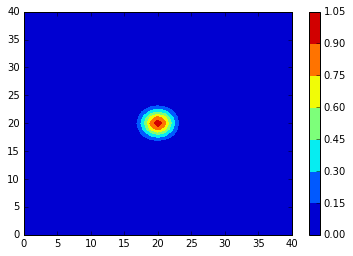

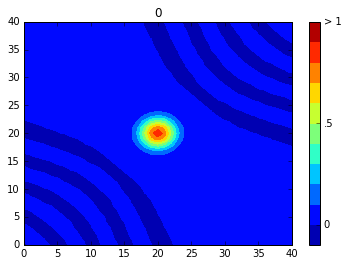

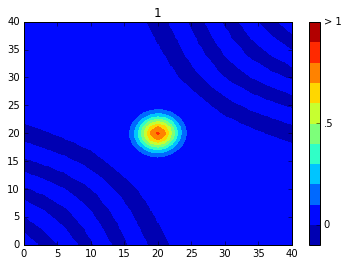

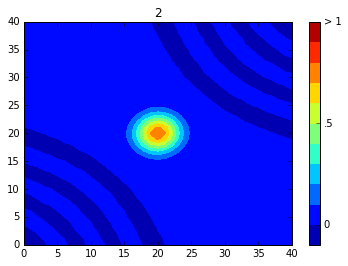

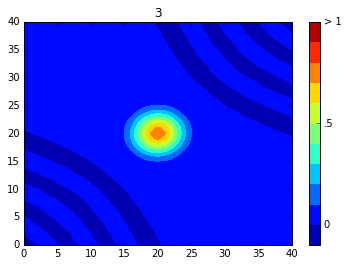

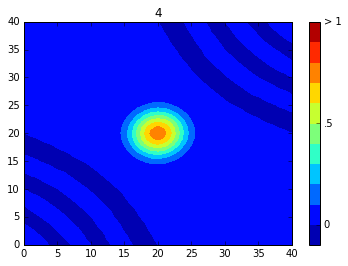

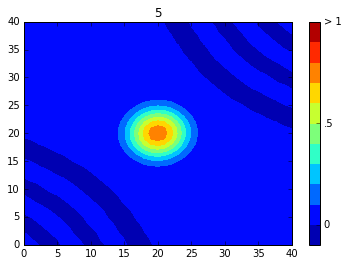

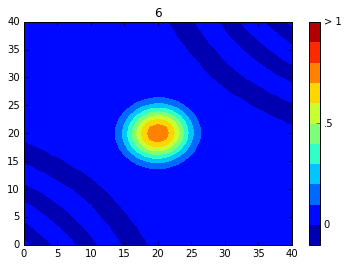

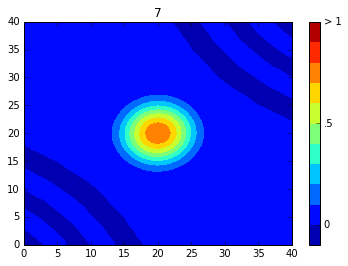

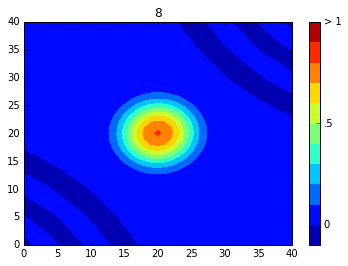

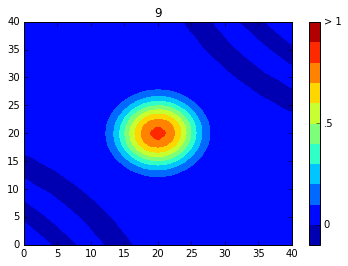

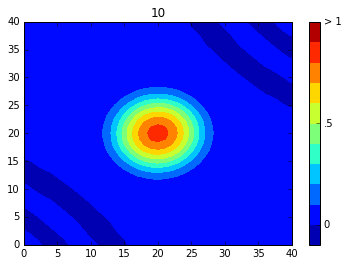

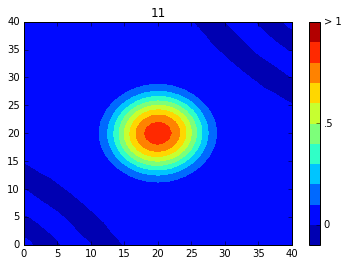

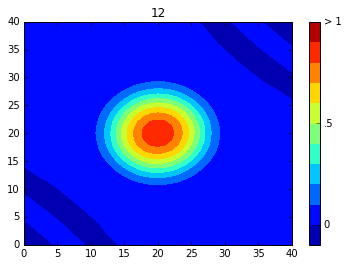

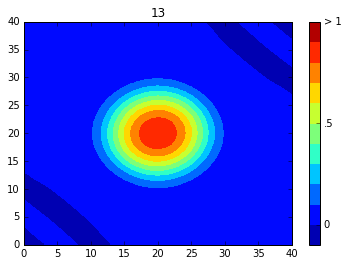

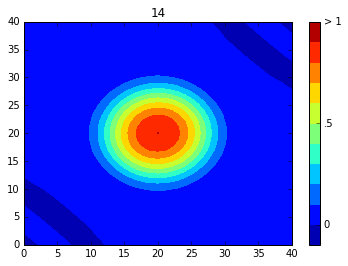

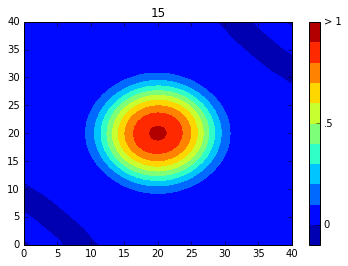

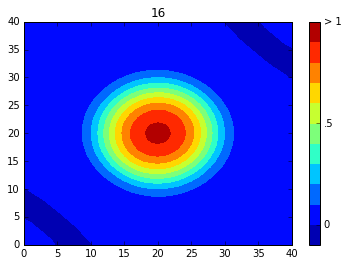

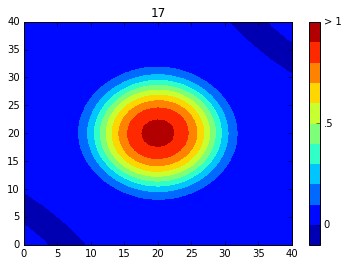

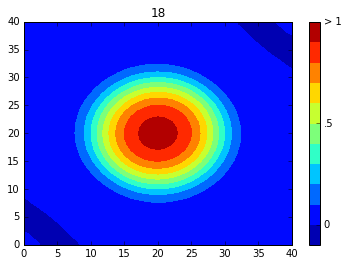

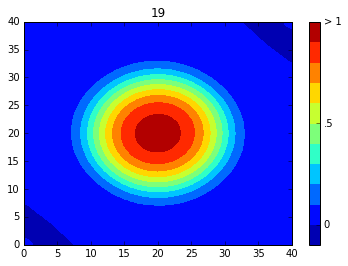

In [5]:
## Reaction Diffusion + Linear Elasticity 

%matplotlib inline
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
import time
import os 

# Variables
T = 1.0            # final time
num_steps = 20     # number of time steps
dt = T / num_steps # time step size
G = 1.0            # shear modulus
lam = .001
nu = lam/(2*(lam+G))
EE = lam*(1+nu)*(1-2*nu)/nu
beta = .001
Dt = .05           # Diffusion coefficient
alphat = 5       # Reaction coeffecient
gamma1 = 10.05       # stress-to-diffusion coefficient
gamma2 = 10.05       # stress-to-reaction coefficient

# Create mesh and define function spaces
nx = ny = 40
mesh = RectangleMesh(Point(-2, -2), Point(2, 2), nx, ny)
V = VectorFunctionSpace(mesh, 'P', 1) # Function space for displacement
W = FunctionSpace(mesh, 'P',1) # Function space for tumor cells

# Define initial fraction of tumor cells
phi_0 = Expression('exp(-a*pow(x[0], 2) - a*pow(x[1], 2))', 
                 degree=2, a=20)
phi_n = interpolate(phi_0,W)
plt.figure()
f = plt.contourf(phi_n.compute_vertex_values().reshape([nx+1,ny+1]))
plt.colorbar(mappable=f)

# Define expressions and functions used in variational forms
D = project(Constant(Dt),W)   # Parameter 1
alpha = project(Constant(alphat),W)
k = Constant(dt)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, Constant((0.0,0.0)), boundary)

# Define von mises stress using Cauchy stress for Compressible neo-Hookean material
def vm(u):
    F = I + grad(u)             # Deformation gradient
    B = F*F.T                   # Left Cauchy-Green tensor 
    J  = det(F)
    s = -lam*(J-1)*I+G/(J**(5./3))*(B-(1./2)*tr(B)*I)
    von_Mises = sqrt(3./2*inner(s, s))
    return project(von_Mises, W)

# Define functions
phi = Function(W)
vR = TestFunction(W)
du = TrialFunction(V)            # Incremental displacement
v  = TestFunction(V)             # Test function
u  = Function(V)                 # Displacement from previous iteration
Bf  = beta*grad(phi_n)            # Body force per unit volume

# Kinematics
I = Identity(2)             # Identity tensor
F = I + grad(u)             # Deformation gradient
C = F.T*F                   # Right Cauchy-Green tensor
Ic = tr(C)                  # Invariants of deformation tensors
J  = det(F)
psi = (G/2)*(Ic - 2) - G*ln(J) + (lam/2)*(ln(J))**2 # Stored strain energy density (compressible neo-Hookean model)
Pi = psi*dx - dot(Bf, u)*dx  # Total potential energy

# Hyperelasticity variational problem
F = derivative(Pi, u, v) # Compute first variation of Pi (directional derivative about u in the direction of v)
J = derivative(F, u, du) # Compute Jacobian of F

# Reaction Diffusion variational problem
FR = (phi - phi_n)*vR*dx \
    + k*D*dot(grad(vR),grad(phi))*dx \
    - k*alpha*phi*(1 - phi)*vR*dx 

# Optimization options for the form compiler
parameters["form_compiler"]["cpp_optimize"] = True
ffc_options = {"optimize": True}    
    
# Compute solution
os.system('rm ./rdhyper/*')
phifile = XDMFFile('rdhyper/solution.xdmf')
phi.rename("phi","")
u.rename("disp","")
t = 0
for n in range(num_steps):
    t += dt
    
    # Solve variational problem for time step
    solve(F == 0, u, bc, J=J, form_compiler_parameters=ffc_options)
    D = Dt*exp(-gamma1*vm(u))
    alpha = alphat*exp(-gamma2*vm(u))
    solve(FR == 0, phi)
    
    # Save solution to file (xdmf)
    phifile.write(phi,t)
    phifile.write(u,t)
    
    # Update previous solution
    phi_n.assign(phi)
    phiarray = phi_n.compute_vertex_values().reshape([nx+1,ny+1])
    
    # Plot
    fig, ax = plt.subplots()
    cax = ax.contourf(phiarray,np.linspace(-.1,1,12))
    ax.set_title(str(n))
    cbar = fig.colorbar(cax,ticks=[0,.5,1],spacing='proportional')
    cbar.set_ticklabels(['0', '.5', '> 1'])  # vertically oriented colorbar
    plt.show()
    
del phifile